# Mode Solver

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FModeSolver.ipynb).

This tutorial shows how to use the mode solver plugin in tidy3d.

In [1]:
import numpy as np
import matplotlib.pylab as plt

import tidy3d as td
from tidy3d.constants import C_0

## Setup

We first set up the mode solver with information about our system.

We start by setting parameters

In [2]:
# size of simulation domain
Lx, Ly, Lz = 6, 6, 6
dl = .05

# waveguide information 
wg_width = 1.5
wg_height = 1.0
wg_permittivity = 4.0

# frequency we want to solve at (freq0)
wvl_um = 2.0
freq_hz = C_0 / wvl_um

Then we set up a simulation, in this case including a straight waveguide

[17:29:29] WARNING  No sources in simulation.                               ]8;id=651902;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:368

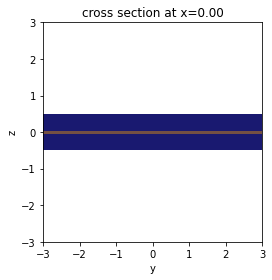

In [3]:
waveguide = td.Structure(
    geometry = td.Box(size=(wg_width, td.inf, wg_height)),
    medium = td.Medium(permittivity=wg_permittivity)
)
monitor = td.FieldMonitor(
    size=(td.inf, td.inf, 0),
    freqs=[freq_hz],
    name='field'
)

sim = td.Simulation(
    size=(Lx, Ly, Lz),
    grid_size=(dl, dl, dl),
    pml_layers=(None, None, None),
    structures=[waveguide],
    monitors=[monitor],
)

ax = sim.plot(x=0)

## Initialize Mode Solver

With our system defined, we can now create our mode solver.

We first need to specify on what plane we want to solve the modes using a `td.Box()` object.

In [4]:
plane = td.Box(
    center=(0,0,0),
    size=(Lx, 0, Lz)
)

Then we can initialize a `ModeSolver()` object to solve for the modes at frequency `freq` on plane `plane` in `sim`.

The mode solver will evaluate the complex-valued permittivity of `simulation` on `plane` at frequency `freq` and use this for the mode solver.

In [5]:
from tidy3d.plugins import ModeSolver

mode_solver = ModeSolver(
    simulation=sim,
    plane=plane,
    freq=freq_hz
)

## Mode specifications

The mode solver can now compute the modes given a `ModeSpec` object that specifies everything about the modes we're looking for, for example:

- `num_modes`: how many modes to compute.

- `target_neff`: float, default=None, initial guess for the effective index of the mode; if not specified, the modes with the largest real part of the effective index are computed.

The full list of specification parameters can be found [here](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.ModeSpec.html#tidy3d.ModeSpec).

In [6]:
mode_spec = td.ModeSpec(
    num_modes=3,
    target_neff=2.0,
)

Once we have the mode specification, we can `solve` for the mode information using our `ModeSolver()` instance.

In [8]:
modes = mode_solver.solve(mode_spec)
first_mode = modes[0]

## Visualizing Mode Data

The `mode_info` object contains information about the effective index of the mode and the field profiles.

The effective index information can be accessed as follows.

In [26]:
n_eff = first_mode.n_eff
k_eff = first_mode.k_eff

print(f'first mode: n_eff = {n_eff:.2f}, k_eff = {k_eff:.2e}')

first mode: n_eff = 1.74, k_eff = -5.46e-18


The `mode_info.field_data` attribute is a `td.FieldData` instance that can be visualized and analyzed using the various methods provided by `FieldData` objects.

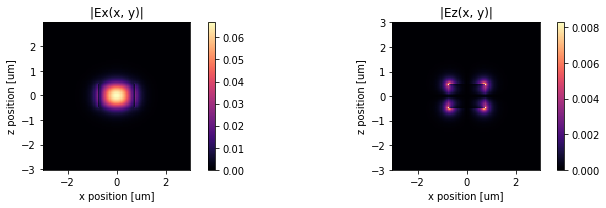

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 3))
abs(first_mode.field_data.Ex).plot(x='x', y='z', ax=ax1, cmap="magma")
abs(first_mode.field_data.Ez).plot(x='x', y='z', ax=ax2, cmap='magma')

ax1.set_title('|Ex(x, y)|')
ax1.set_aspect("equal")
ax2.set_title('|Ez(x, y)|')
ax2.set_aspect("equal")
plt.show()

## Choosing the mode of interest

We can also look at the other modes that were computed.

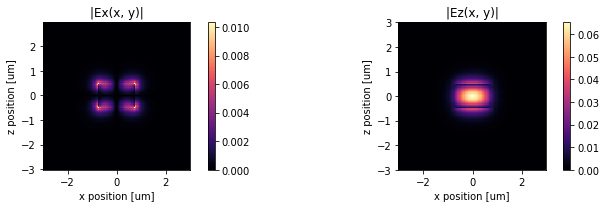

second mode: n_eff = 1.68, k_eff = 4.56e-18


In [27]:
second_mode = modes[1]
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 3))
abs(second_mode.field_data.Ex).plot(x='x', y='z', ax=ax1, cmap="magma")
abs(second_mode.field_data.Ez).plot(x='x', y='z', ax=ax2, cmap='magma')
ax1.set_title('|Ex(x, y)|')
ax1.set_aspect("equal")
ax2.set_title('|Ez(x, y)|')
ax2.set_aspect("equal")
plt.show()
print(f'second mode: n_eff = {second_mode.n_eff:.2f}, k_eff = {second_mode.k_eff:.2e}')

This looks like an Ez-dominant mode, if instead we wanted a higher order Ey-dominant mode. Finally, the even higher-order mode has mixed polarization.

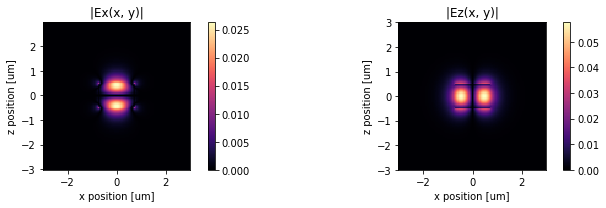

third mode: n_eff = 1.42, k_eff = 9.20e-18


In [28]:
third_mode = modes[2]
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 3))
abs(third_mode.field_data.Ex).plot(x='x', y='z', ax=ax1, cmap="magma")
abs(third_mode.field_data.Ez).plot(x='x', y='z', ax=ax2, cmap='magma')
ax1.set_title('|Ex(x, y)|')
ax1.set_aspect("equal")
ax2.set_title('|Ez(x, y)|')
ax2.set_aspect("equal")
plt.show()
print(f'third mode: n_eff = {third_mode.n_eff:.2f}, k_eff = {third_mode.k_eff:.2e}')

## Exporting Results

This looks promising!

Now we can choose the mode specifications to use in our mode source and mode monitors. These can be exported directly from the mode solver, for example:

In [40]:
# makes a modal source with geometry of `plane`, source_time given by `freq_hz` and `fwidth` and `mode` specified by `mode`
mode_src = mode_solver.to_source(mode_spec=mode_spec, mode_index=2, fwidth=freq_hz/10, direction='-')

# makes a mode monitor with geometry of `plane`, `td.FreqSampler` given by a list of frequencies and `mode` specified by `mode`
mode_mon = mode_solver.to_monitor(mode_spec=mode_spec, freqs=[0.9 * freq_hz, freq_hz, 1.1*freq_hz], name='mode')

In [42]:
sim = td.Simulation(
    size=(Lx, Ly, Lz),
    grid_size=(dl, dl, dl),
    run_time=20/fwidth,
    pml_layers=(td.PML(), td.PML(), td.PML()),
    structures=[waveguide],
    sources=[mode_source],
    monitors=[monitor]
)

In [43]:
import tidy3d.web as web
job = web.Job(simulation=sim, task_name='mode_simulation')
sim_data = job.run(path='data/simulation_data.hdf5')

[17:54:21] INFO     Uploaded task 'mode_simulation' with task_id                ]8;id=248367;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:108
                    'cc52e3a4-93d6-4e06-9282-85f956e5812d'.

Output()

[17:54:37] status = preprocess                                               ]8;id=432303;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/container.py\container.py]8;;\:144

[17:54:56] status = running                                                  ]8;id=621900;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/container.py\container.py]8;;\:144

[17:55:11] status = postprocess                                              ]8;id=714845;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/container.py\container.py]8;;\:144

[17:55:26] status = success                                                  ]8;id=258996;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/container.py\container.py]8;;\:144

[17:55:27] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=213772;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:484
                    "data/simulation_data.hdf5"

Output()

           INFO     loading SimulationData from data/simulation_data.hdf5       ]8;id=434572;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:303

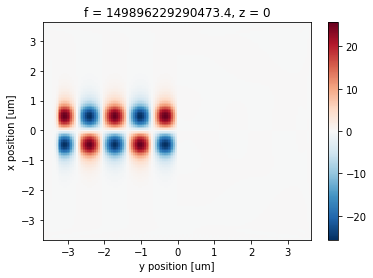

In [44]:
ax = sim_data['field'].Ez.interp(z=0).real.plot()

## Advanced Use

Here are some more advanced functionalities of the mode solver for practical use:

### "Scanning" modes
One might want to view how a mode behaves over a range of frequencies, for now, just iterate:

freq = 600 THz
	- neff = 1.96
	- keff = -1.30e-18
freq = 400 THz
	- neff = 1.91
	- keff = 8.21e-12
freq = 300 THz
	- neff = 1.84
	- keff = 3.00e-18
freq = 240 THz
	- neff = 1.76
	- keff = -1.69e-10
freq = 200 THz
	- neff = 1.66
	- keff = -3.28e-18


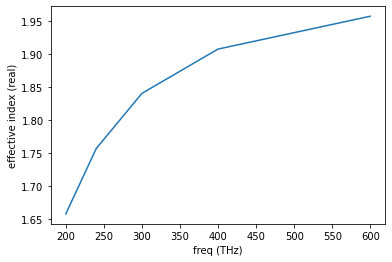

In [45]:
freqs = C_0 / np.linspace(0.5, 1.5, 5)
neffs = []
mode_index = 2
for freq in freqs:
    mode_solver = ModeSolver(
        simulation=sim,
        plane=plane,
        freq=freq)
    mode_info = mode_solver.solve(mode_spec)[mode_index]
    print(f'freq = {(freq/1e12):.0f} THz\n\t- neff = {mode_info.n_eff:.2f}\n\t- keff = {mode_info.k_eff:.2e}')
    neffs.append(mode_info.n_eff)
    # or, get field data and plot
    
plt.plot(freqs / 1e12, neffs)
plt.xlabel('freq (THz)')
plt.ylabel('effective index (real)')
plt.show()

### Viewing multiple mode specifications
One might want to view multiple mode specifications side by side, for now, just iterate:

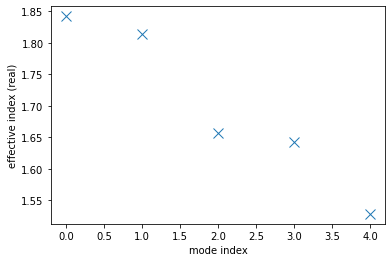

In [56]:
mode_indices = np.arange(0, 5)
mode_solver = ModeSolver(
    simulation=sim,
    plane=plane,
    freq=freq)
mode_spec = td.ModeSpec(num_modes=max(mode_indices)+1)

modes = mode_solver.solve(mode_spec)
neffs = [mode.n_eff for mode in modes]

plt.plot(mode_indices, neffs, 'x', ms=10)
plt.xlabel('mode index')
plt.ylabel('effective index (real)')
plt.show()

## Notes / Considerations

- This mode solver runs locally, which means it does not require credits to run.
- It also means that the mode solver does not use subpixel-smoothening, even if this is specified in the simulation.  Therefore, the results might not perfectly match what we compute with `simulation.subpixel=True`.
- Symmetries are applied to the cross section of the permittivity parsed from the simulation.  It uses the upper quadrant data to fill the full `plane`.  